# Camera Calibration
The code in this notebook will later be broken apart into separate packages. Currently, this notebook is for prototyping.

Starting the experimentation with the test images.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from os import path
%matplotlib inline

In [2]:
"""
Calibrate the camera given a directory containing calibration chessboards.

param dir: directory containing chessboard frames
param nx: Chessboard corners on x axis
param ny: Chessboard corners on y axis
param img_prefix: The repeating prefix used to name calibration images
param img_type: Calibration image filetype
param verbose: if True, draw and show chessboard corners
return: calibration parameters
"""
def camera_calibration(dir="camera_cal", nx=9, ny=6, img_prefix = "", img_type="jpg", verbose=False):
    assert path.exists(dir), dir + " does not exist. Need a valid directory containing calibration images"
    # 3d points in real world space
    objpoints = []
    # 2d points in image plane
    imgpoints = []
    
    #prep objpoints so it looks like (0, 0, 0), (1, 0, 0), ... (nx, ny, 0)
    # the z coordinate is always zero
    objp = np.zeros((nx*ny, 3), np.float32)
    
    # mgrid returns the coordinate values for a given grid size --> [nx, ny]
    # we are shaping the coordinates from mgrid back into 2 columns --> (x, y)
    # this is to create image points, look at distorted calibration image and detect corners
    # of board
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    images = glob.glob(path.join(dir,img_prefix+"*."+img_type))
    
    assert len(images) > 0, "There are no images to calibrate the camere."
    
    for file in images:
        img = cv2.imread(file)
        # convert images to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # find corners, if they exist
        ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)
        
        # if corners were detected, append the points to imgpoints, and objp to objpoints
        if ret:
            # print("Adding image and object points")
            # print(len(corners))
            # print(len(objp))
            imgpoints.append(corners)
            objpoints.append(objp)
            # displaying images if verbose option was set
            if verbose:
                img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)
                plt.show()
        
    # print(len(objpoints))
    # print(len(imgpoints))
        
    # returning hte calibration parameters
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [3]:
"""
Undistort the images in the given directory.

param mtx: Camera Matrix
param dist: Distortion Coefficients
param dir: directory containing chessboard frames
param img_prefix: The repeating prefix used to name distorted images
param img_type: Distorted image filetype
"""
def undistort_images(mtx, dist, dir="test_images", img_prefix = "", img_type="jpg"):
    assert path.exists(dir), dir + " does not exist. Need a valid directory containing distorted images"
    
    # reading all filenames of distorted images
    images = glob.glob(path.join(dir, img_prefix + "*." + img_type))
    assert len(images) > 0, "There are no images to undistort the camere."
    
    for file in images:
        img = cv2.imread(file)
        undistort = cv2.undistort(img, mtx, dist, None, mtx)
        
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB))
        plt.show()

"""
Undistort the given image.

param img: Distorted Image
param mtx: Camera Matrix
param dist: Distortion Coefficients
return: Undistorted Image
"""
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


# Displaying the Calibration Images with Corners Drawn

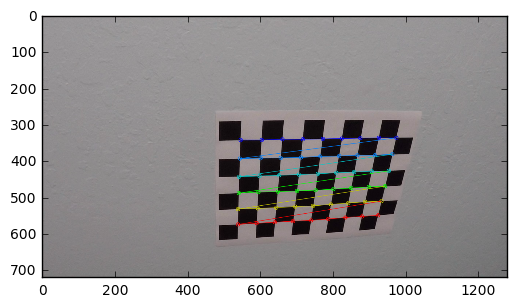

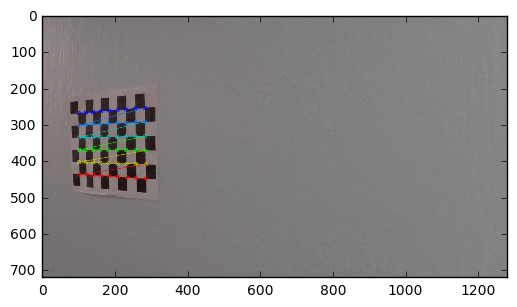

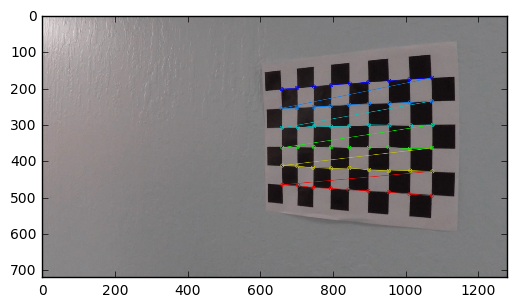

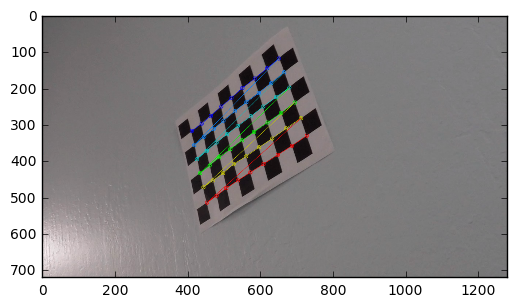

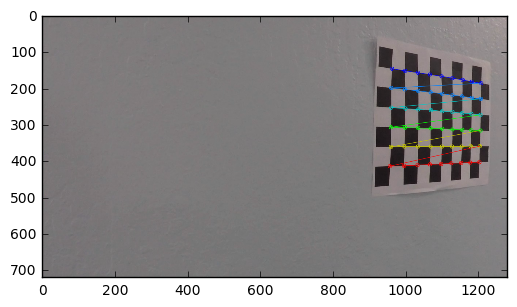

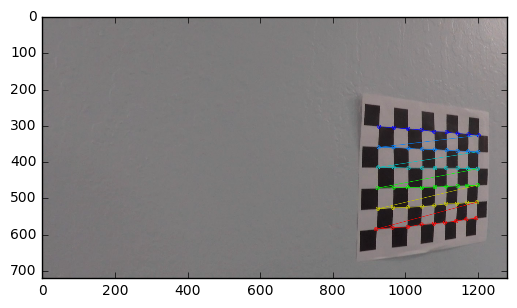

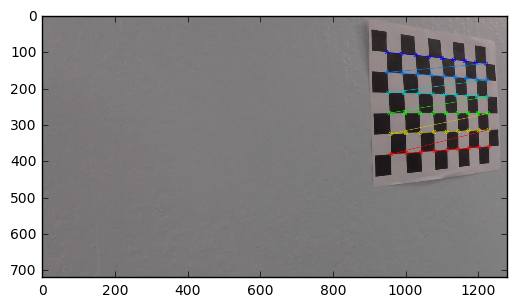

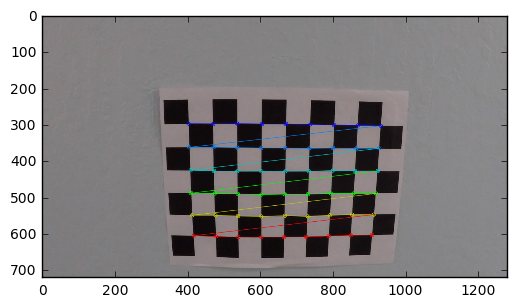

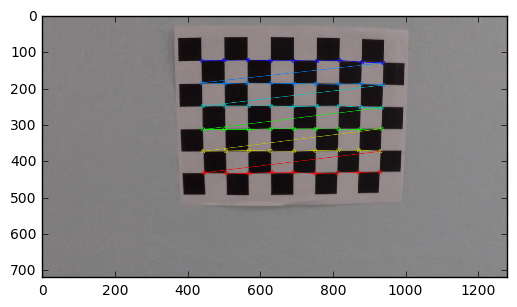

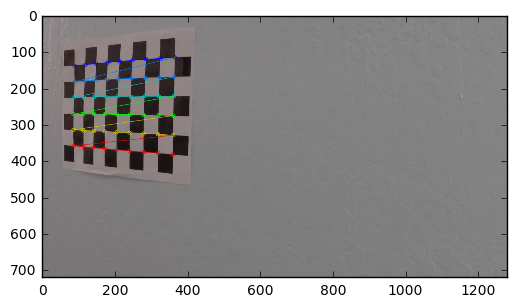

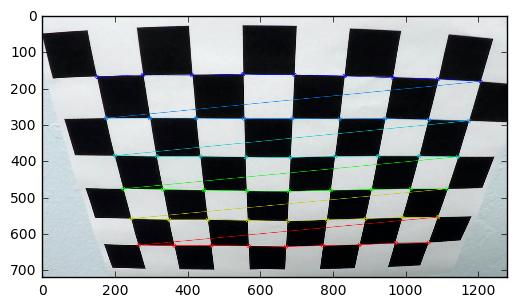

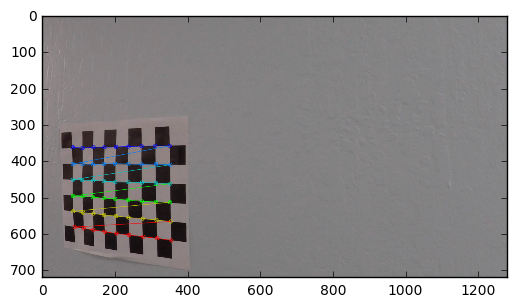

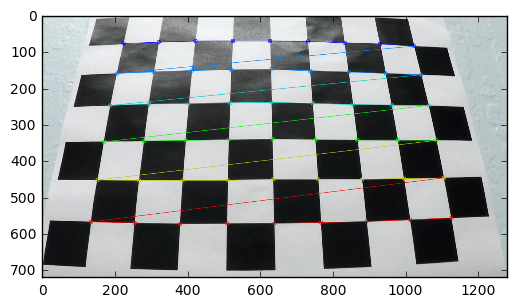

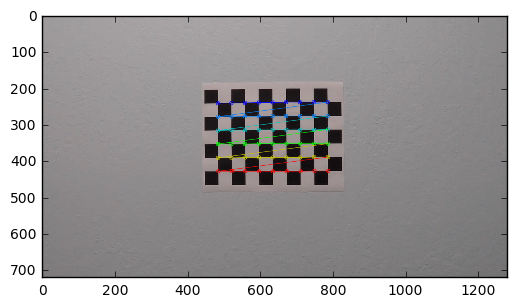

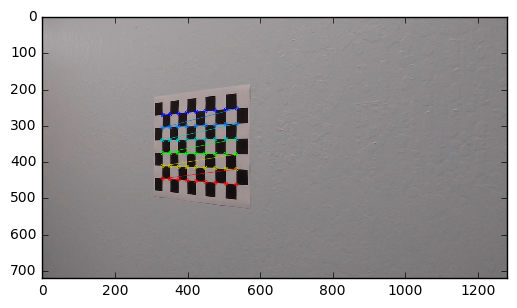

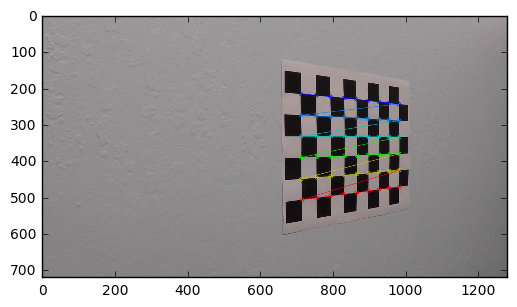

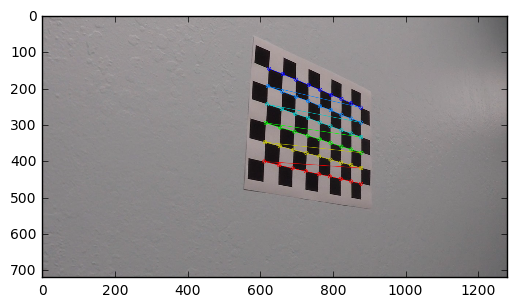

In [4]:
ret, mtx, dist, rvecs, tvecs = camera_calibration(verbose=True)

# Displaying undistorted images

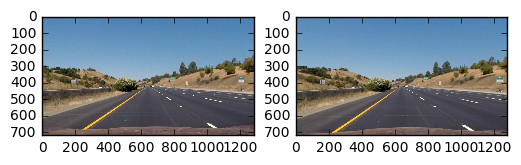

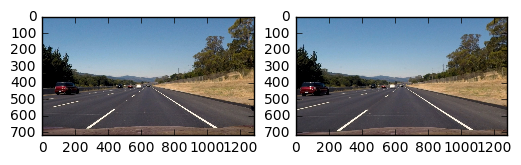

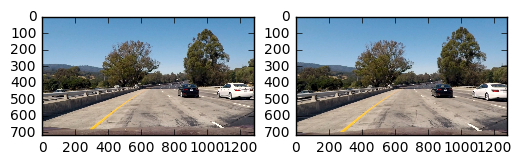

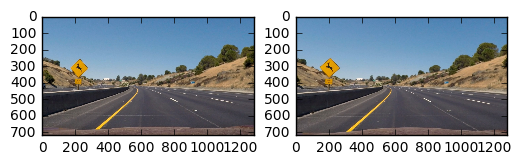

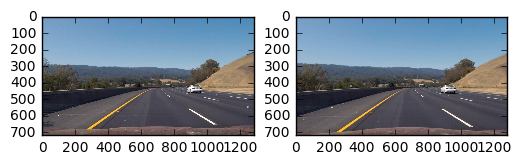

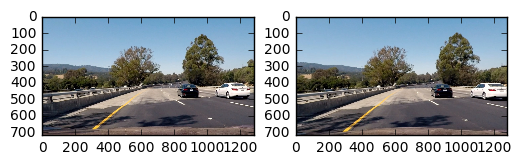

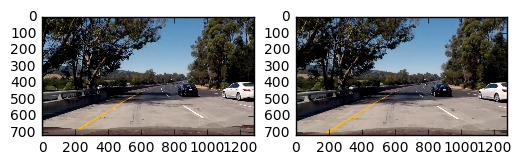

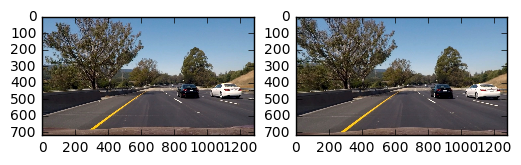

In [5]:
undistort_images(mtx, dist)

# Image Thresholding
Going to implement image thresholding here. This will be used to find the lanes.

In [6]:
"""
Acquires the Sobel Gradient

param gray: grayscale image
param thres: Tuple containing threshold values in range [0, 255]
param kernel: kernel size for sobel operation
return: Binary image  
"""
def Sobel(gray, thres = (20, 100), kernel = 3):
    # Sobel Gradient 
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    
    abs_sobelx = np.absolute(x)
    abs_sobely = np.absolute(y)
    
    # rescaling to 8 bit
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    # print(scaled_sobelx.shape)
    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    # print(scaled_sobely.shape)
    
    sobel_binx = np.zeros_like(scaled_sobelx)
    sobel_binx[((scaled_sobelx >= thres[0]) & (scaled_sobelx <= thres[1]))] = 1
    
    sobel_biny = np.zeros_like(scaled_sobely)
    sobel_biny[((scaled_sobely >= thres[0]) & (scaled_sobely <= thres[1]))] = 1
    
    return sobel_binx, sobel_biny
    
"""
Acquires the Magnitude of the  Gradient

param gray: grayscale image
param thres: Tuple containing threshold values in range [0, 255]
param kernel: kernel size for sobel operation
return: Binary image  
"""
def Magnitude(gray, thres = (20, 100), kernel = 3):
    # Sobel Gradient 
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    
    # Gradient Magnitude
    magnitude = np.sqrt(x**2 + y**2)
    
    # rescaling to 8 bit
    scaled_magnitude = np.max(magnitude)/255
    magnitude = np.uint8(magnitude / scaled_magnitude)
    # print(magnitude.shape)
    mag_bin = np.zeros_like(magnitude)
    mag_bin[((magnitude >= thres[0]) & (magnitude <= thres[1]))] = 1
    return mag_bin

"""
Acquires the Direction of the Gradient

param gray: grayscale image
param thres: Tuple containing threshold values in range [0, 255]
param kernel: kernel size for sobel operation
return: Binary image  
"""
def Direction(gray, thres = (0.7, 1.3), kernel = 15):
    # Sobel Gradient 
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    
    # Gradient Direction
    direction = np.arctan2(np.absolute(y), np.absolute(x))
    dir_bin = np.zeros_like(direction)
    dir_bin[((direction >= thres[0]) & (direction <= thres[1]))] = 1
    return dir_bin

"""
Combine Thresholds, excluding S channel

param sobelx: Sobel Binary on X axis
param sobely: Sobel Binary on Y axis
param magnitude: Magnitude of Gradient
param direction: Direction of Gradient
param verbose: If True, displays all inputs and output
return: Binary Image 
"""
def Combine(sobelx, sobely, magnitude, direction, verbose = False):
    # print(direction.shape)
    output = np.zeros_like(direction)
    output[(((sobelx == 1) & (sobely == 1)) | ((magnitude == 1) & (direction == 1)))]= 1
    
    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(sobelx, cmap = "gray")
        ax[0].set_title("sobel_binx")
        ax[1].imshow(sobely, cmap = "gray")
        ax[1].set_title("sobel_biny")
        fig2, ax2 = plt.subplots(nrows=1, ncols=2)
        ax2[0].imshow(magnitude, cmap = "gray")
        ax2[0].set_title("magnitude")
        ax2[1].imshow(direction, cmap = "gray")
        ax2[1].set_title("direction")
        fig3, ax3 = plt.subplots(nrows=1, ncols=1)
        ax3.imshow(output, cmap = "gray")
        ax3.set_title("Gradient Binary")
        plt.show()
        
    return output

In [7]:
"""
Isolates the S channel in HLS space, and returns a binary image.

param img: BGR image
param verbose: If True, displays the binary image
return: Binary image with S channel isolated
"""
def HLS(img, thresS = (170, 255), thresH = (70, 100), verbose = False):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # isolating the S channel
    S = hls[:,:,2]
    S_bin = np.zeros_like(S)
    S_bin[((S >= thresS[0]) & (S <= thresS[1]))] = 1
    
    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(S, cmap = "gray")
        ax[0].set_title("S Channel")
        ax[1].imshow(S_bin, cmap = "gray")
        ax[1].set_title("S Channel Isolated Binary")
        plt.show()
    return S_bin

In [8]:
"""
Transforms input image to highlight the lanes lines as much as possible

param img: undistorted image
param verbose: if True, visualize transformation process
return: binary image
"""
def transform_image(img, verbose = False):
    height, width = img.shape[:2]
    
    #grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx, sobely = Sobel(gray, kernel = 7)
    magnitude = Magnitude(gray, kernel = 7)
    direction = Direction(gray, kernel = 21)
    hls_bin = HLS(img, verbose=verbose)
    gradient = Combine(sobelx, sobely, magnitude, direction, verbose = verbose)
    
    combined = np.zeros_like(gradient)
    combined[((gradient == 1) | (hls_bin == 1))] = 1
    
    if verbose:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Input")
        plt.show()
        plt.imshow(combined, cmap = "gray")
        plt.title("Thresholded Binary")
        plt.show()
        
    return combined

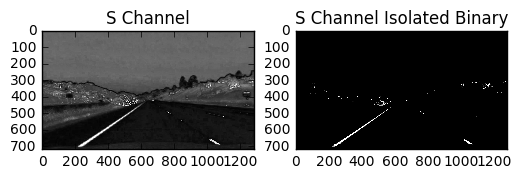

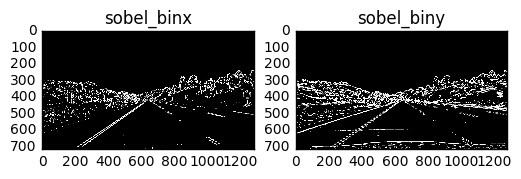

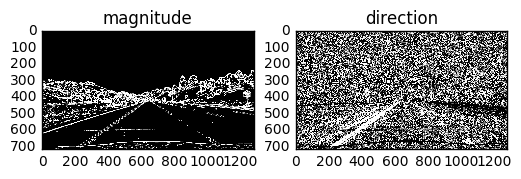

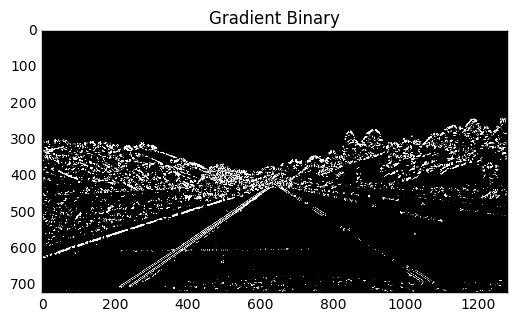

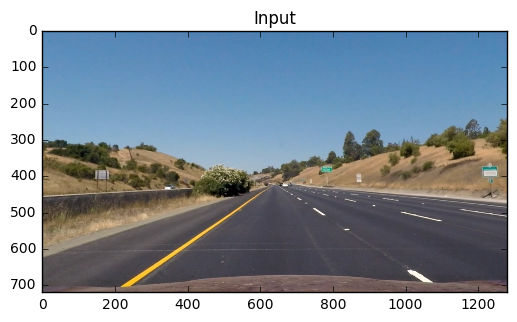

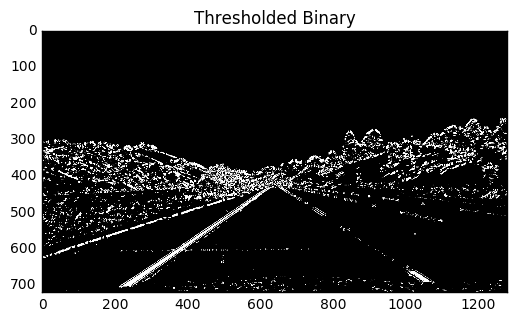

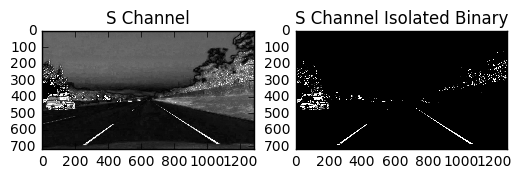

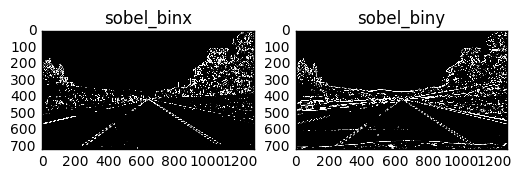

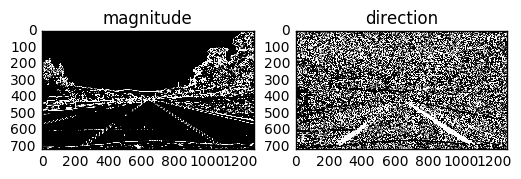

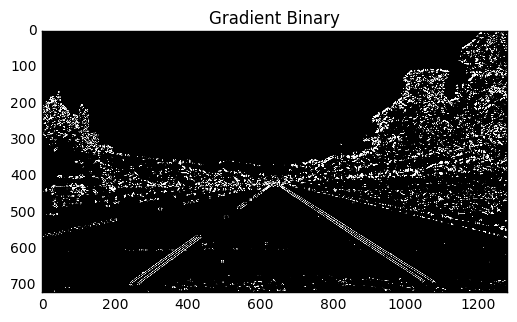

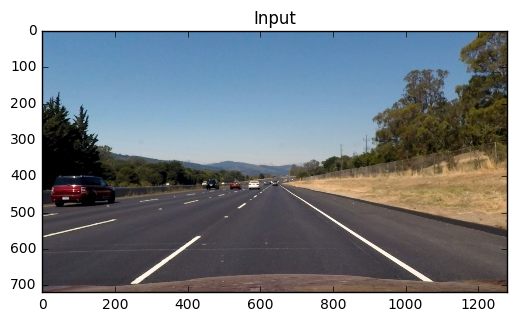

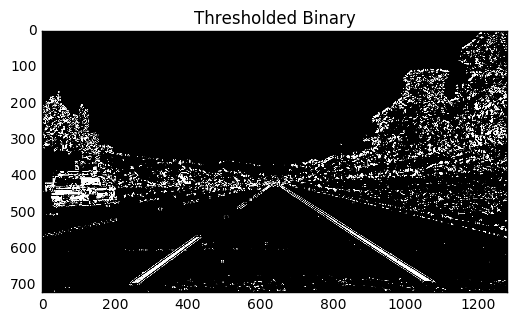

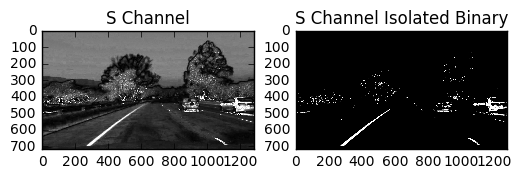

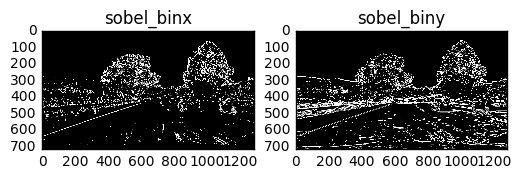

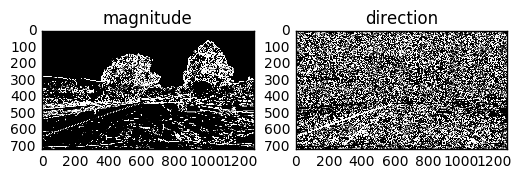

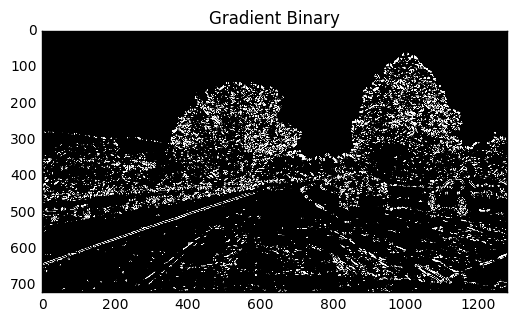

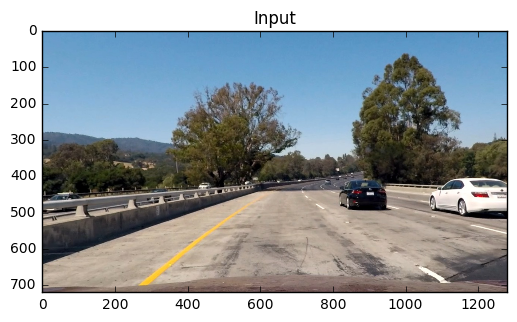

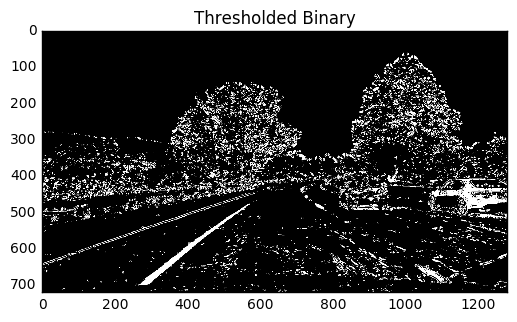

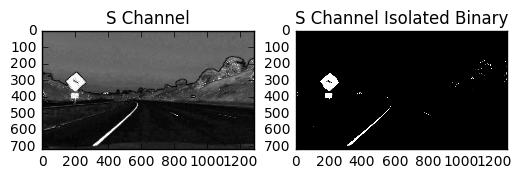

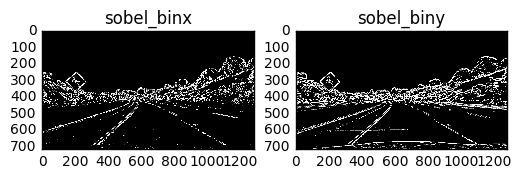

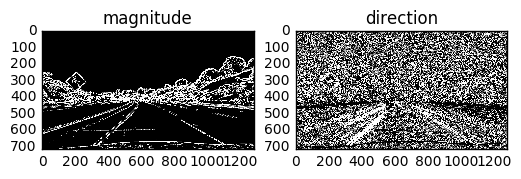

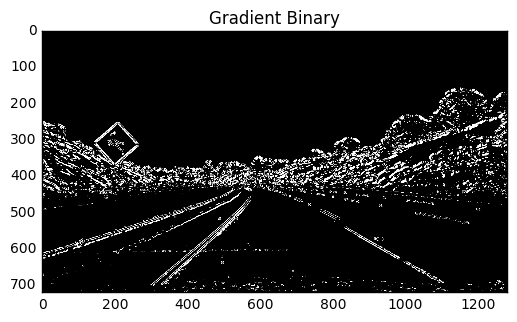

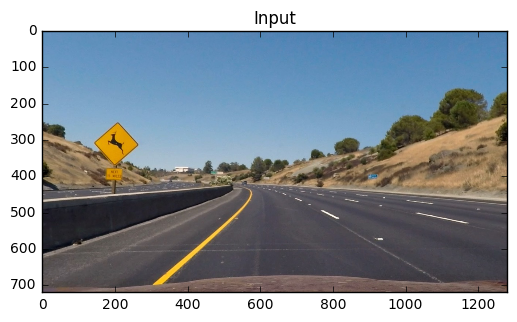

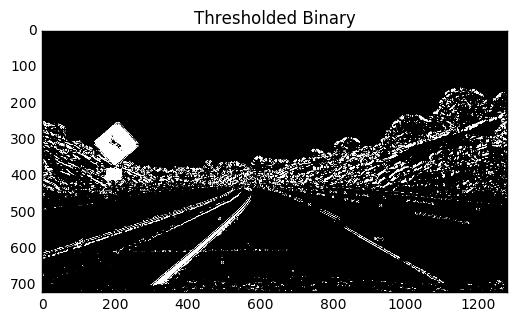

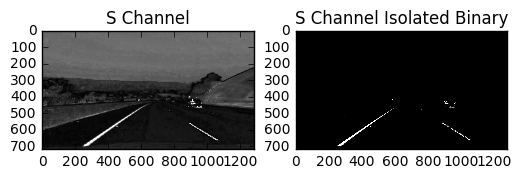

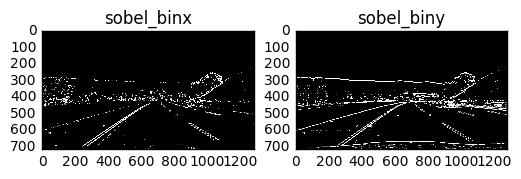

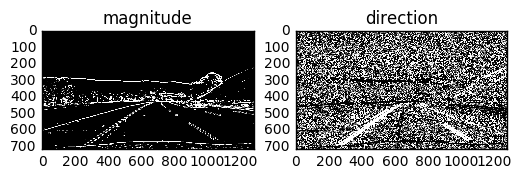

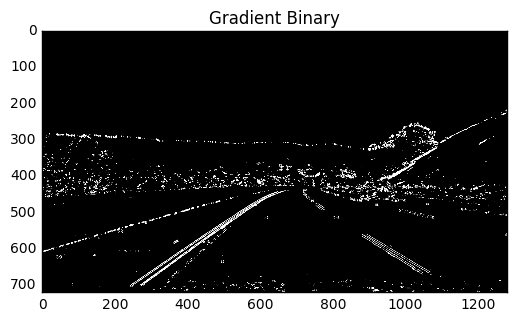

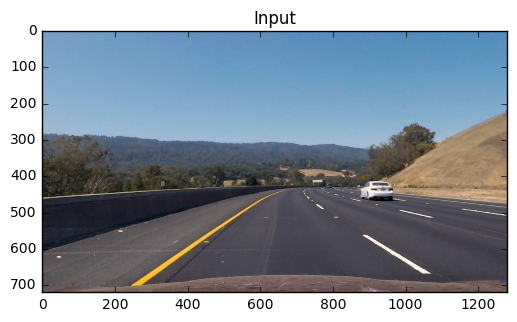

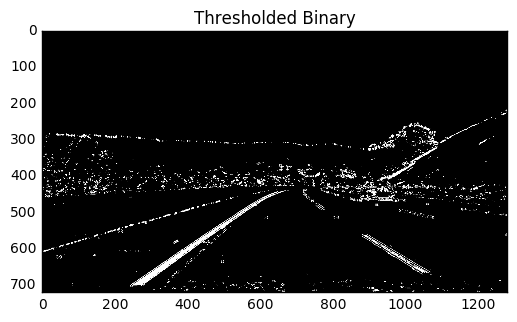

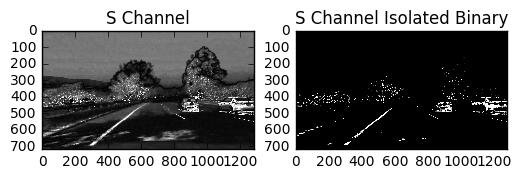

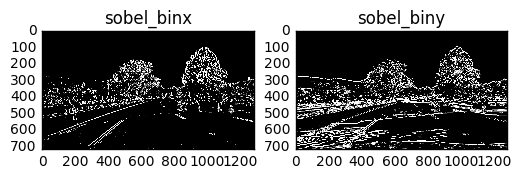

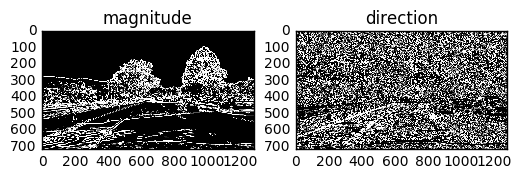

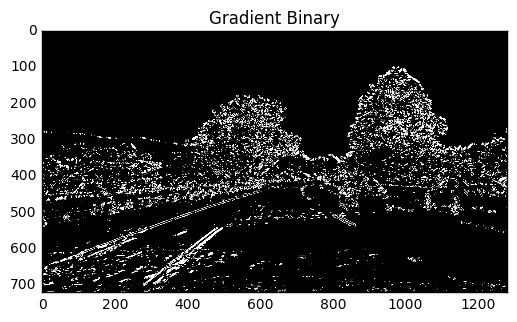

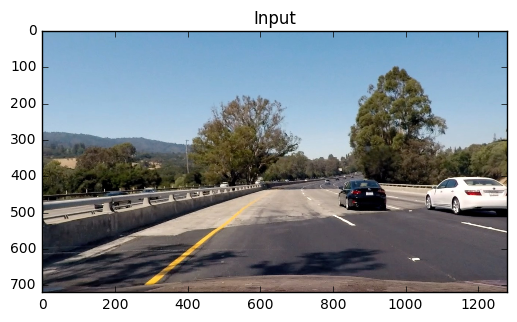

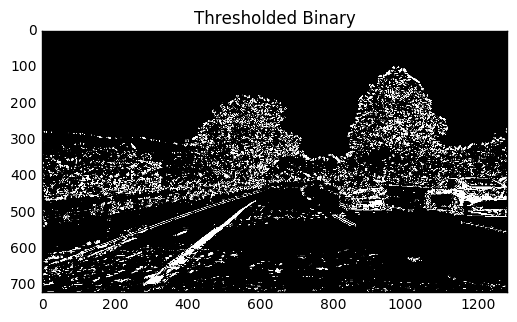

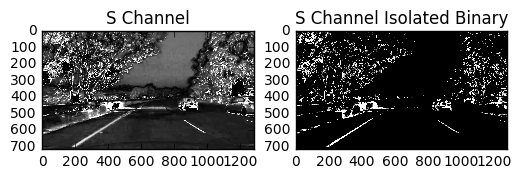

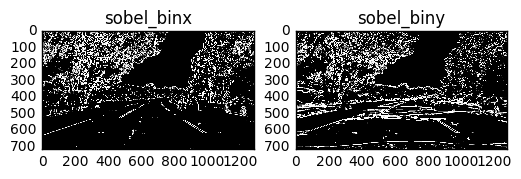

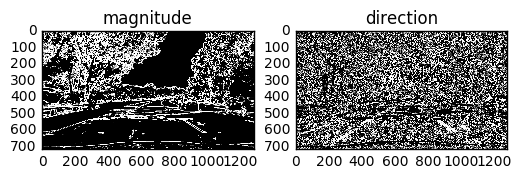

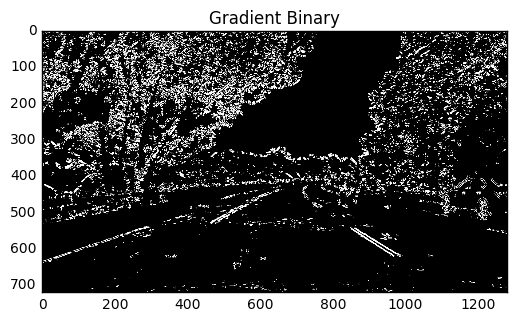

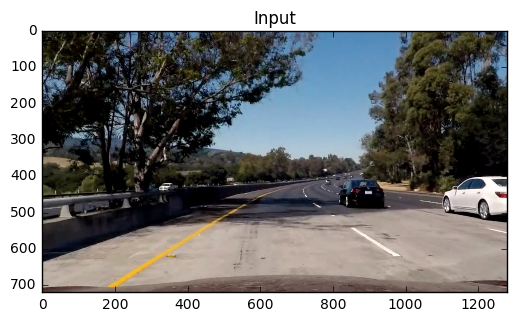

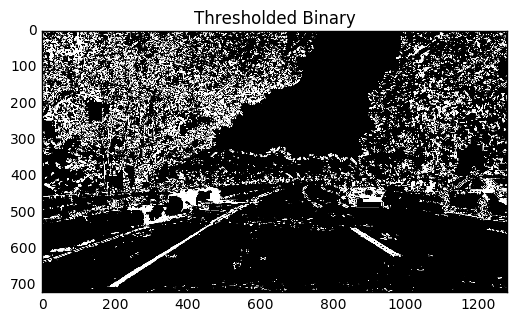

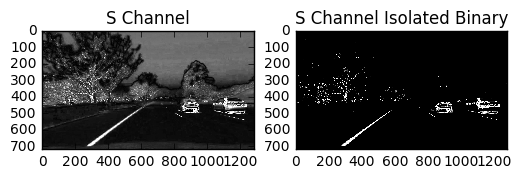

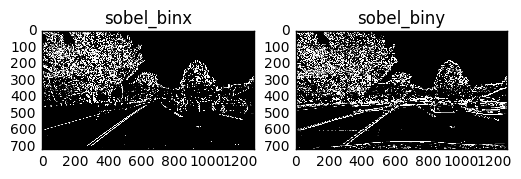

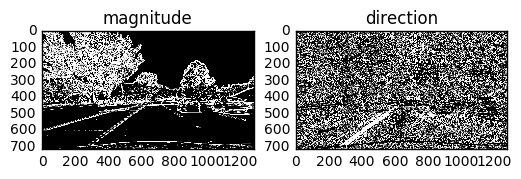

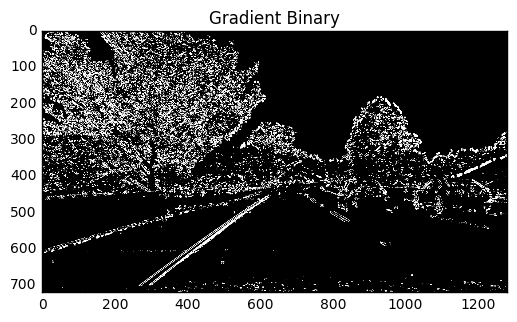

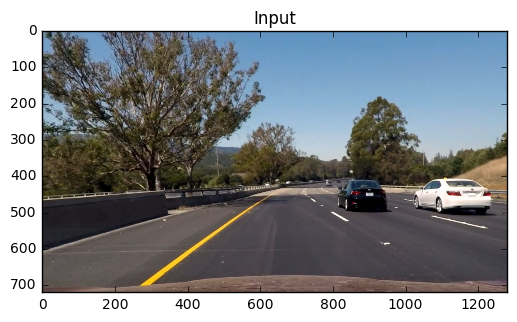

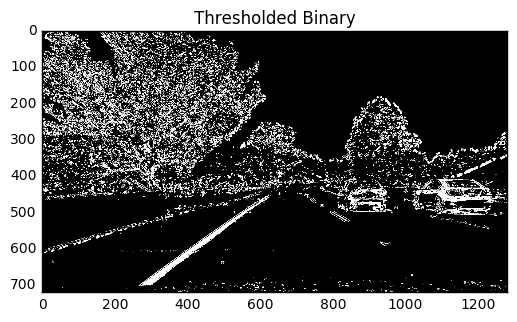

In [9]:
test_images = glob.glob('test_images/*.jpg')

transformed_view = []

for test_image in test_images:
    img = cv2.imread(test_image)
    img = undistort_image(img, mtx, dist)
    transformed_view.append(transform_image(img, verbose = True))

# Perspective Transform
I am implementing perspective transform here to get a bird's eye view of the road.

In [18]:
"""
Applies a perspective transform to the provided image.

param img: Undistorted image
param verbose: If True, will display transformed image
return: Warped image
"""
def perspective_transform(img, verbose = False):
    # defining calibration box in source and destination coordinates
    img_size = (img.shape[1], img.shape[0])
    
    # print(img_size)
    
    # 4 source coordinates for transform
    p1 = [767, 480] # topRx, topRy
    p2 = [1200, 680]# bottomRx, bottomRy
    p3 = [250, 680]# bottomLx, bottomLy
    p4 = [547, 480]# topLx, topLy
    
    # the source points for the lane lines 
    src = np.float32([p1, p2, p3, p4])
    
    offset = 200
    
    # the destination points that define how the new image should look
    # [350, 350], [930, 720], [350, 720], [930, 350]
    dst = np.float32([[img_size[0] - offset, offset],
                      [img_size[0] - offset, img_size[1]],
                      [offset, img_size[1]],
                      [offset, offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    # applies a transform to the original image
    warped =  cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    if verbose:
        plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        plt.title("Bird's Eye View")
        plt.show()
    
    return warped

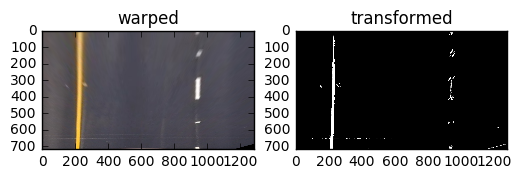

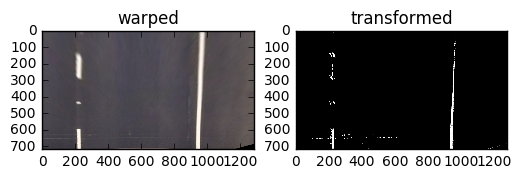

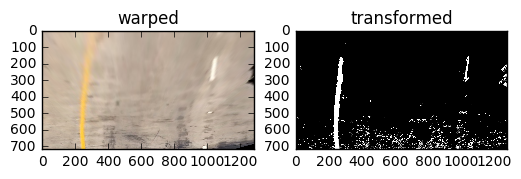

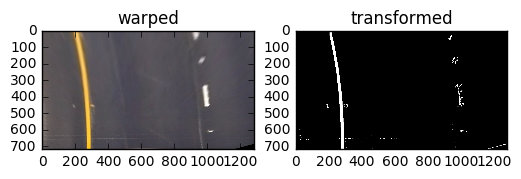

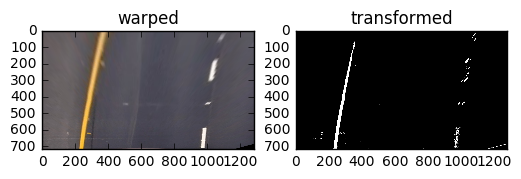

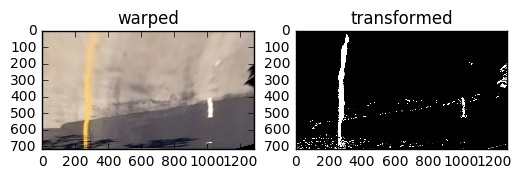

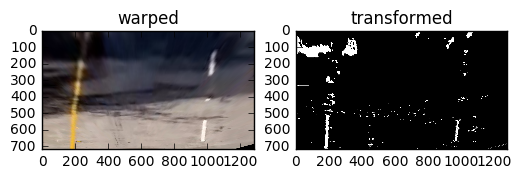

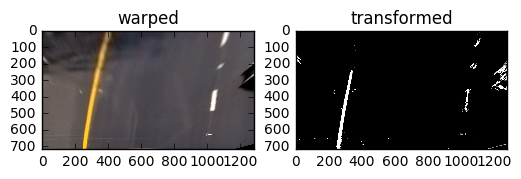

In [19]:
test_images = glob.glob('test_images/*.jpg')
birdseye = []

for test_image in test_images:
    img = cv2.imread(test_image)
    img = undistort_image(img, mtx, dist)
    warped = perspective_transform(img, verbose = False)
    transformed = transform_image(warped)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax[0].set_title("warped")
    ax[1].imshow(transformed, cmap = "gray")
    ax[1].set_title("transformed")
    
    birdseye.append(transformed)

# Lane Finding
This portion concerns finding the location of lanes in each image.

In [12]:
assert len(transformed_view) == len(birdseye), "Length of transformed_view != Length of birdseye"

ValueError: object too deep for desired array